In [1]:
# Imports
# !pip install torchinfo
import torch
import torch.nn as nn
import torch.utils.data as Data
from torchvision import datasets, transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import os
# os.environ['OPENBLAS_NUM_THREADS'] = '1'
import numpy as np
import random
import time
import TrainerVTS_V08C1 as TP
import DataSetting_v2 as DS

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

### Loader

In [2]:
gpu = 5
date = '240603'
#run = ['30', '100', '300', '900']
run = '300'
exp = 'Prop_noil'

In [3]:
datadir = f'../dataset/0509/make19_{run}-split/'
data = DS.ModalityLoader(data_dir=datadir)
train_set = DS.MyDataset('tv', data.train_data)
test_set = DS.MyDataset('test', data.test_data)
train_loader, valid_loader = DS.DataSplitter(train_set).split_loader()
test_loader = DS.DataSplitter(test_set, 1).gen_loader()

Loading from ../dataset/0509/make19_300-split/


  0%|          | 0/20 [00:00<?, ?it/s]

Generating loaders...
 tv len 4181, distributed=False
 exported train loader of len 52, batch size 64
 exported valid loader of len 13, batch size 64

Generating loaders...
 test len 5299, distributed=False
 exported loader of len 5299, batch size 1


### Teacher

In [4]:
torch.cuda.set_device(gpu)
imgencoder = TP.ImageEncoder(latent_dim=16)
imgdecoder = TP.ImageDecoder(latent_dim=16)

T_trainer = TP.TeacherTrainer(beta=0.5, 
                              mask=True,
                              recon_lossfunc=nn.MSELoss(reduction='sum'),
                              name='Teacher', networks=[imgencoder, imgdecoder],
                              epochs=10, cuda=gpu,
                              loss_optimizer = {'LOSS': [torch.optim.Adam, 1e-4]},
                              train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader,
                              notion=f"{date}_{run}_{exp}")

Teacher train: epoch=1/999, batch=0/60, loss=404.2196, current best valid loss=382.9086    
Teacher train: epoch=1/999, batch=5/60, loss=424.7654, current best valid loss=382.9086    
Teacher train: epoch=1/999, batch=10/60, loss=436.9654, current best valid loss=382.9086    
Teacher train: epoch=1/999, batch=15/60, loss=441.1630, current best valid loss=382.9086    
Teacher train: epoch=1/999, batch=20/60, loss=407.4075, current best valid loss=382.9086    
Teacher train: epoch=1/999, batch=25/60, loss=404.1824, current best valid loss=382.9086    
Teacher train: epoch=1/999, batch=30/60, loss=459.3962, current best valid loss=382.9086    
Teacher train: epoch=1/999, batch=35/60, loss=439.3591, current best valid loss=382.9086    
Teacher train: epoch=1/999, batch=40/60, loss=447.2827, current best valid loss=382.9086    
Teacher train: epoch=1/999, batch=45/60, loss=431.6700, current best valid loss=382.9086    
Teacher train: epoch=1/999, batch=50/60, loss=422.9442, current best val

<Figure size 432x288 with 0 Axes>

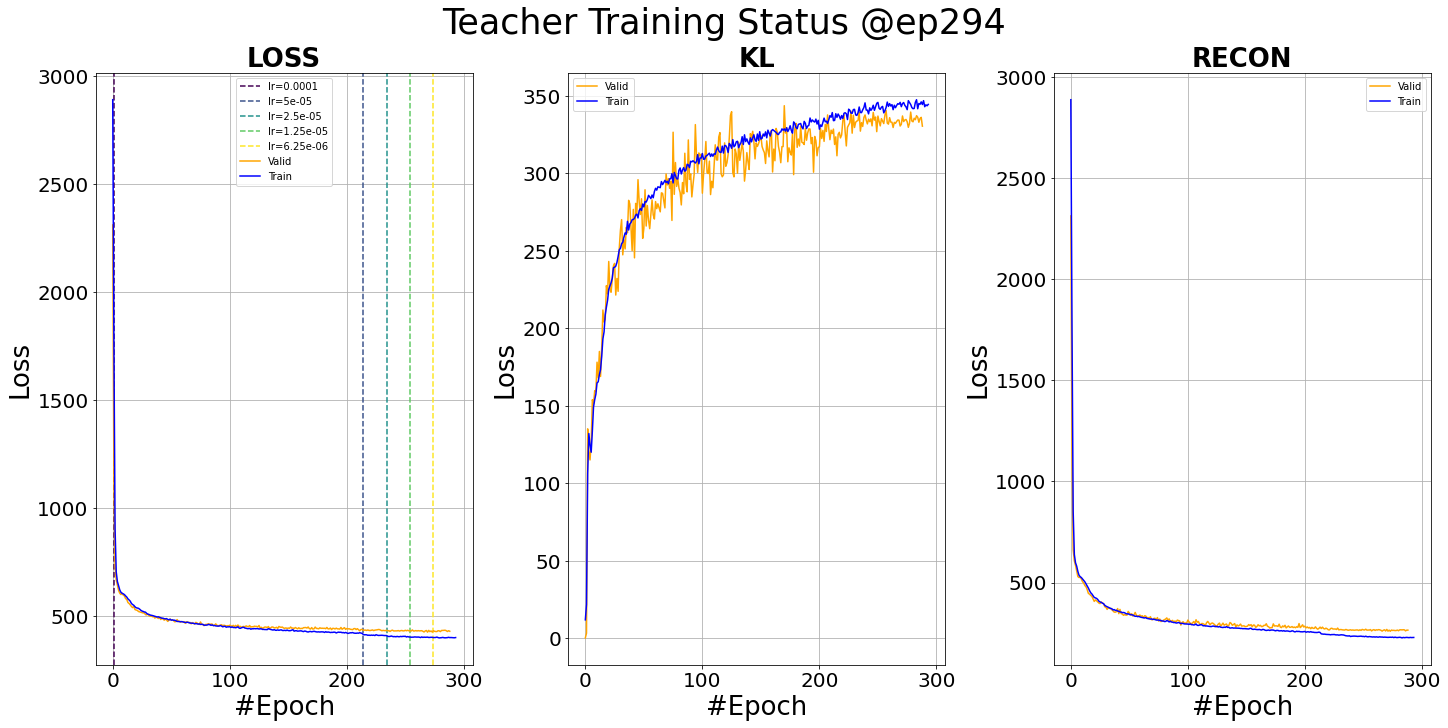

Teacher test: sample=55/60, loss=243.6037    
Test finished. Average loss={'LOSS': 230.33518132567406, 'KL': 5.402529269363731, 'RECON': 227.63391673763593}

Total training time: 16.21820878982544 sec


<Figure size 1440x720 with 0 Axes>

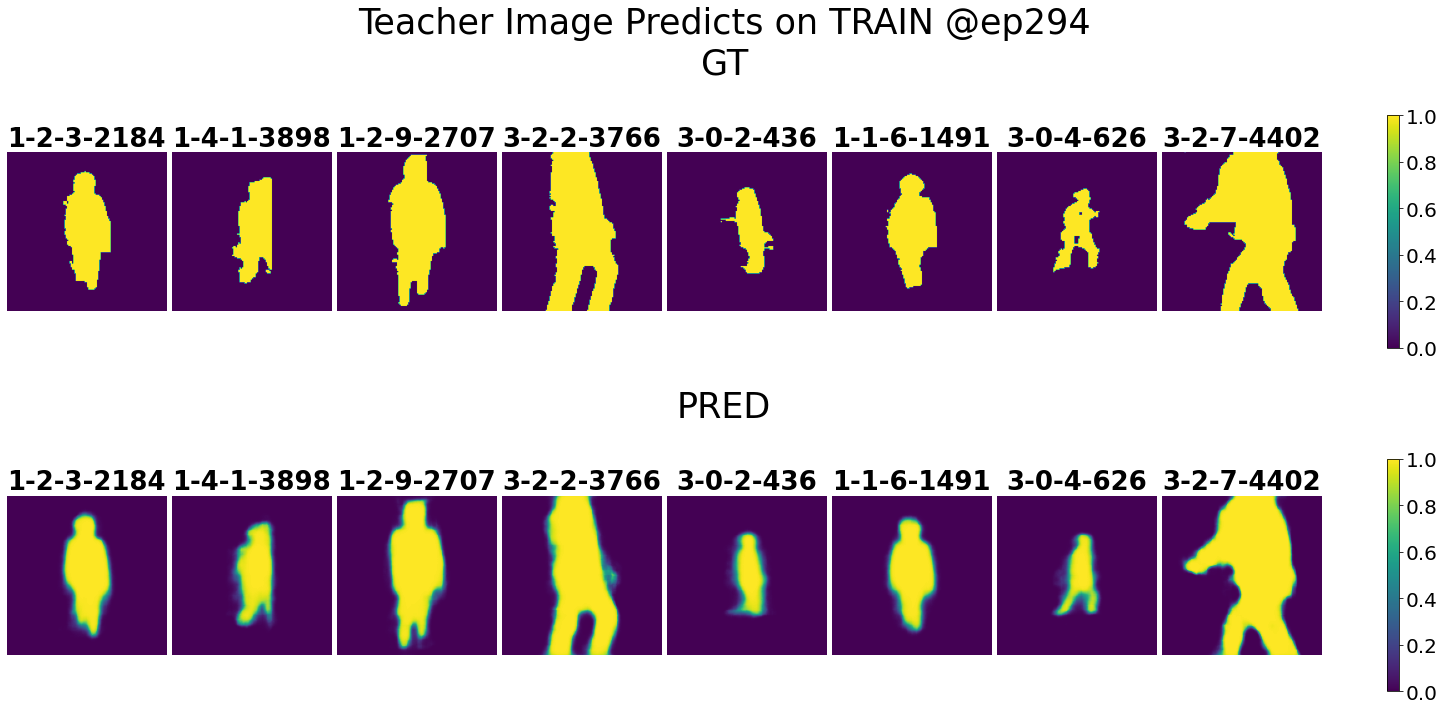

<Figure size 1440x720 with 0 Axes>

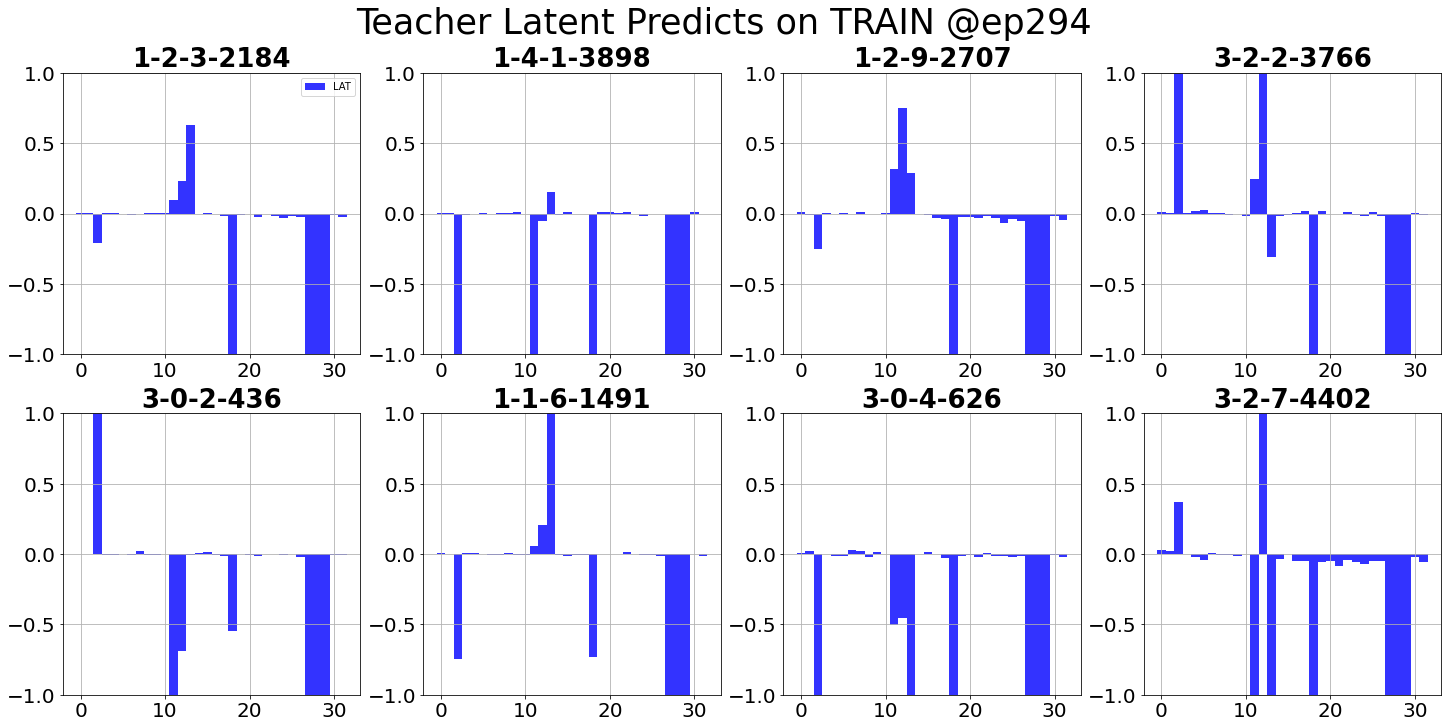

Teacher test: sample=5700/5701, loss=127.2854     
Test finished. Average loss={'LOSS': 280.148903330676, 'KL': 4.767577400669218, 'RECON': 277.7651147486097}

Total training time: 51.526501178741455 sec


<Figure size 1440x720 with 0 Axes>

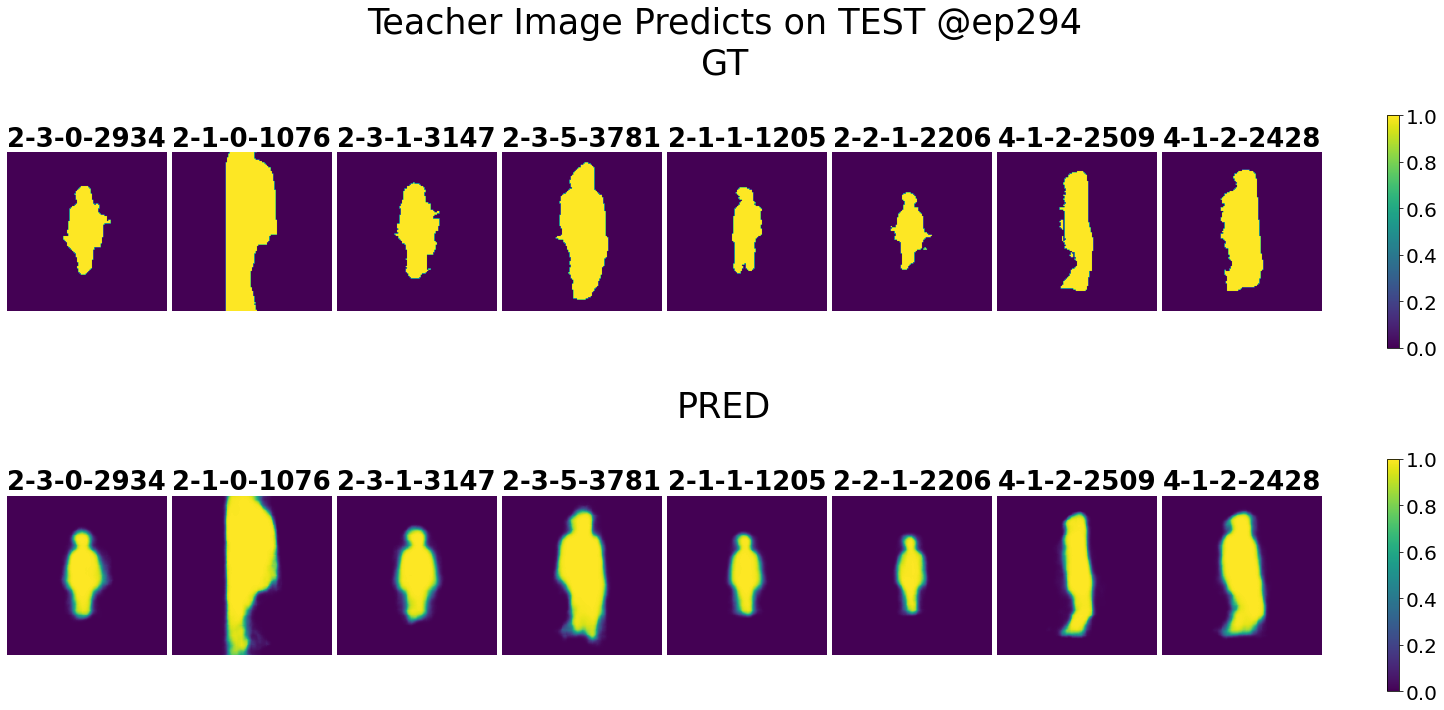

<Figure size 1440x720 with 0 Axes>

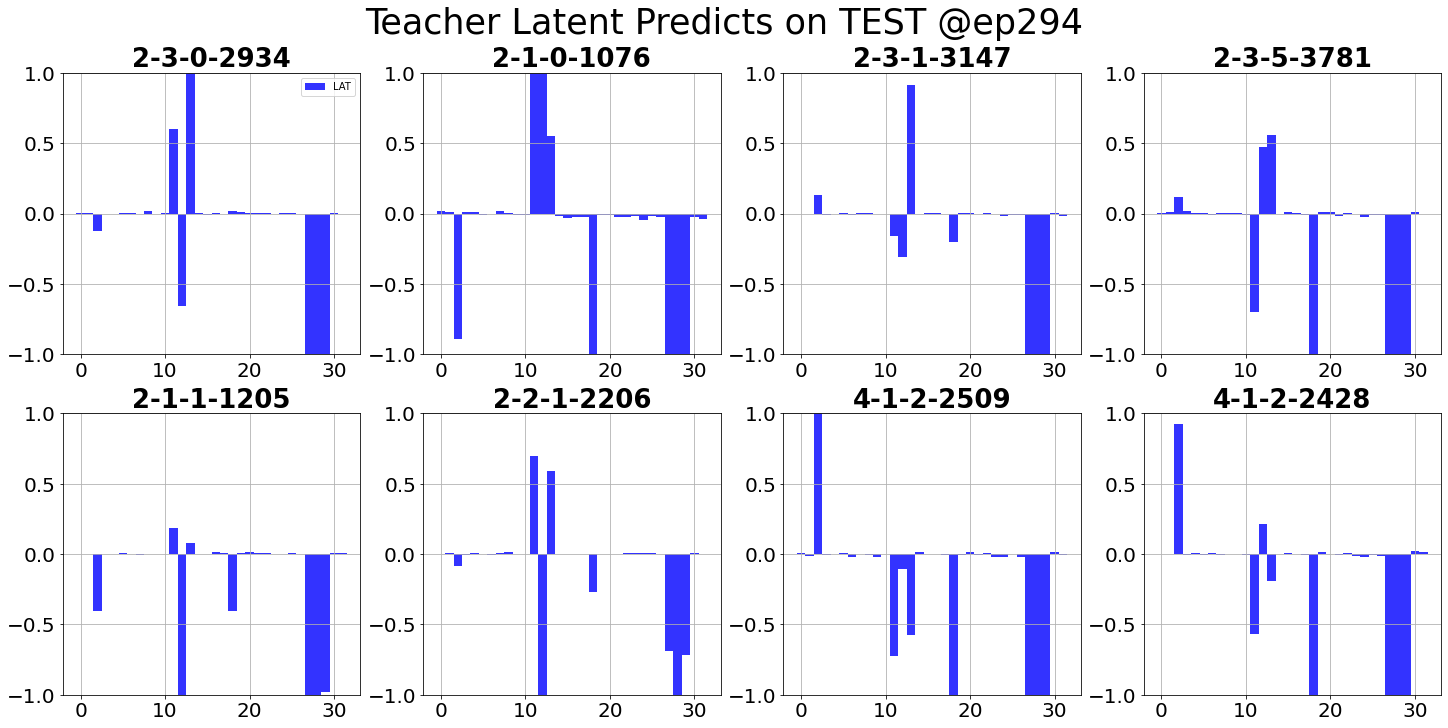

Saving pred: GT...Saving pred: PRED...Saving pred: LAT...Saving pred: TAG...Done

Teacher schedule Completed!


In [9]:
### Scheduler
%matplotlib inline
T_trainer.lr = 1e-4
T_trained = T_trainer.schedule(lr_decay=True)

### Student

In [4]:
torch.cuda.set_device(gpu)
csiencoder = TP.CSIEncoder(lstm_steps=75)
centerdecoder = TP.CenterDecoder()
imgencoder = TP.ImageEncoder(latent_dim=16)
imgdecoder = TP.ImageDecoder(latent_dim=16)
imgencoder.load_state_dict(torch.load(f"../saved/240603_30_Prop_Teacher/Teacher_IMGENV08C1_best.pth"))
imgdecoder.load_state_dict(torch.load(f"../saved/240603_30_Prop_Teacher/Teacher_IMGDEV08C1_best.pth"))
#csiencoder.load_state_dict(torch.load(f"../saved/240527_30_Prop/Student_CSIENV08C1_best.pth"))
#centerdecoder.load_state_dict(torch.load(f"../saved/240527_30_Prop/Student_CTRDEV08C1_best.pth"))

S_trainer = TP.StudentTrainer(name='Student', mask=True, with_img_loss=False,
                              networks=[csiencoder, centerdecoder, imgencoder, imgdecoder],
                              lr=1e-4, epochs=10, cuda=gpu,
                              loss_optimizer = {'LOSS': [torch.optim.Adam, 1e-4]},
                              notion=f"{date}_{run}_{exp}",
                              train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader,
                             )

Student train: epoch=1/999, batch=0/52, loss=0.1765, current best valid loss=inf    
Student train: epoch=1/999, batch=5/52, loss=0.1201, current best valid loss=inf    
Student train: epoch=1/999, batch=10/52, loss=0.1066, current best valid loss=inf    
Student train: epoch=1/999, batch=15/52, loss=0.0903, current best valid loss=inf    
Student train: epoch=1/999, batch=20/52, loss=0.0992, current best valid loss=inf    
Student train: epoch=1/999, batch=25/52, loss=0.0949, current best valid loss=inf    
Student train: epoch=1/999, batch=30/52, loss=0.0934, current best valid loss=inf    
Student train: epoch=1/999, batch=35/52, loss=0.0692, current best valid loss=inf    
Student train: epoch=1/999, batch=40/52, loss=0.0725, current best valid loss=inf    
Student train: epoch=1/999, batch=45/52, loss=0.0682, current best valid loss=inf    
Student train: epoch=1/999, batch=50/52, loss=0.0908, current best valid loss=inf    

Student valid: epoch=1/999, batch=0/13, loss=0.0756, cu

<Figure size 432x288 with 0 Axes>

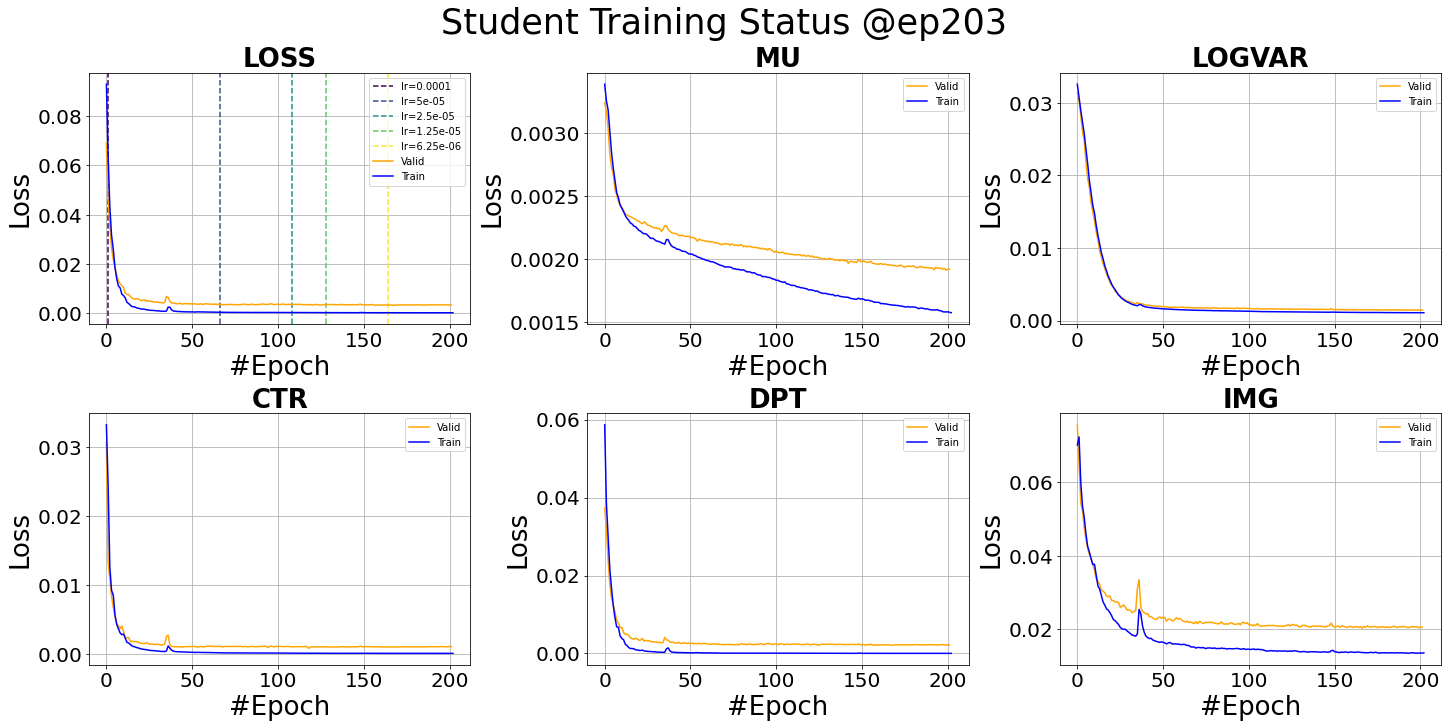

/home/bob/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/bob/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Student test: sample=50/52, loss=0.0283    
Test finished. Average loss={'LOSS': 0.00940389996914676, 'MU': 0.10013784146639619, 'LOGVAR': 0.06803848981546533, 'CTR': 1.9439513099742017e-05, 'DPT': 1.2663030990783221e-05, 'IMG': 0.012999063970360462}

Total training time: 35.53261852264404 sec


<Figure size 1440x720 with 0 Axes>

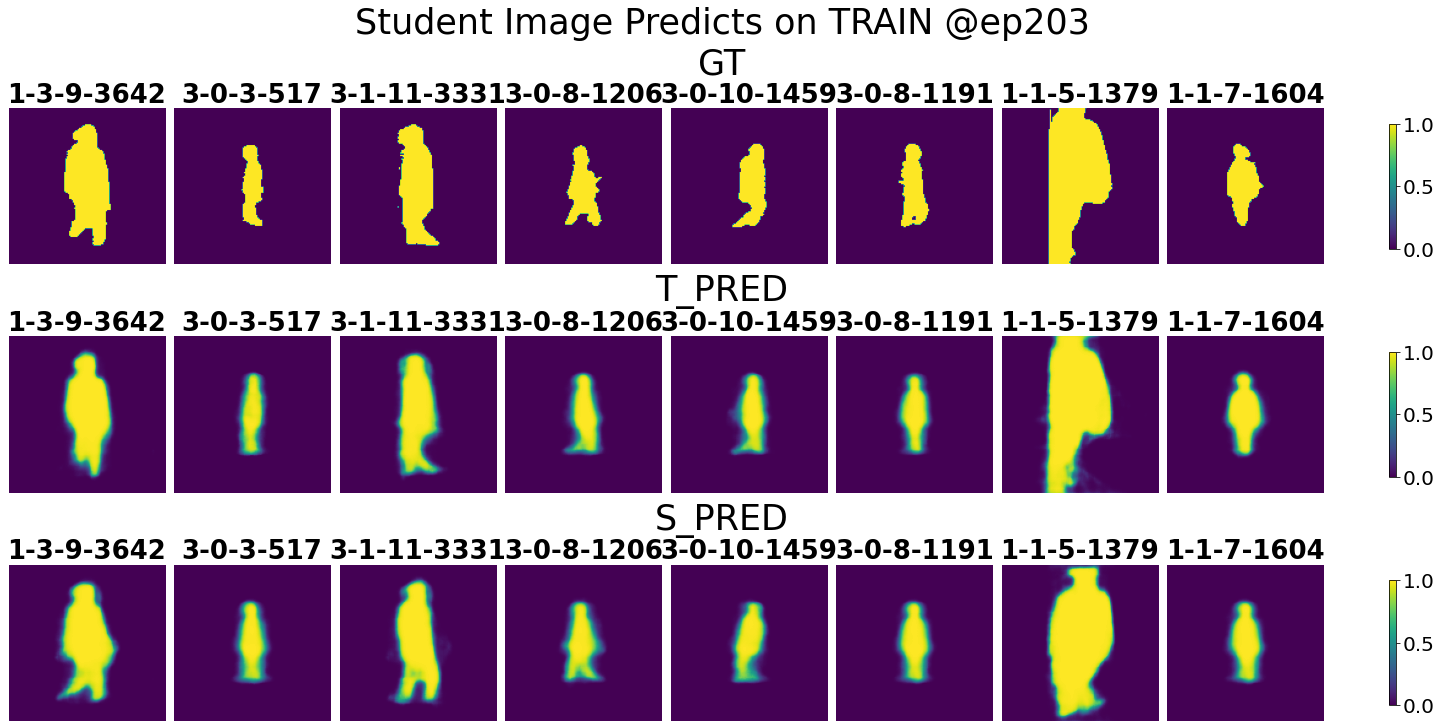

<Figure size 1440x720 with 0 Axes>

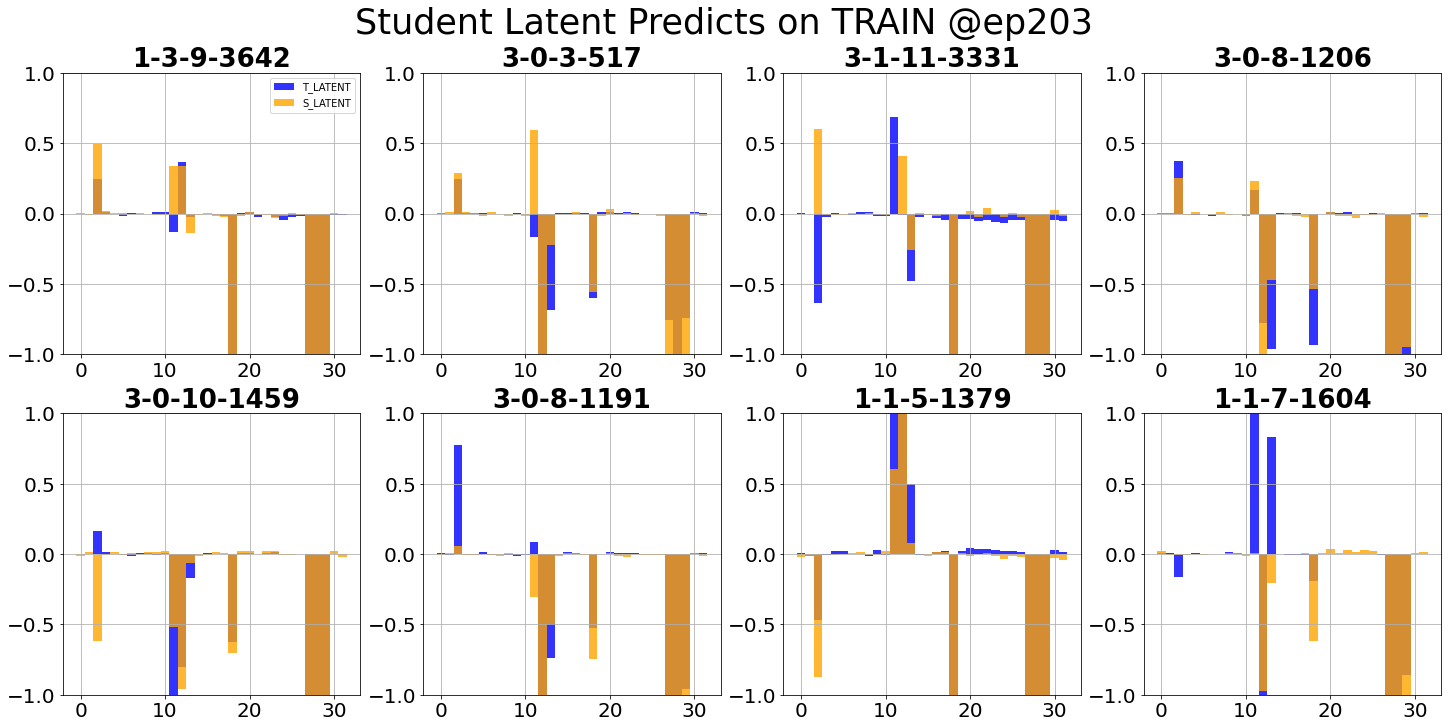

<Figure size 1440x720 with 0 Axes>

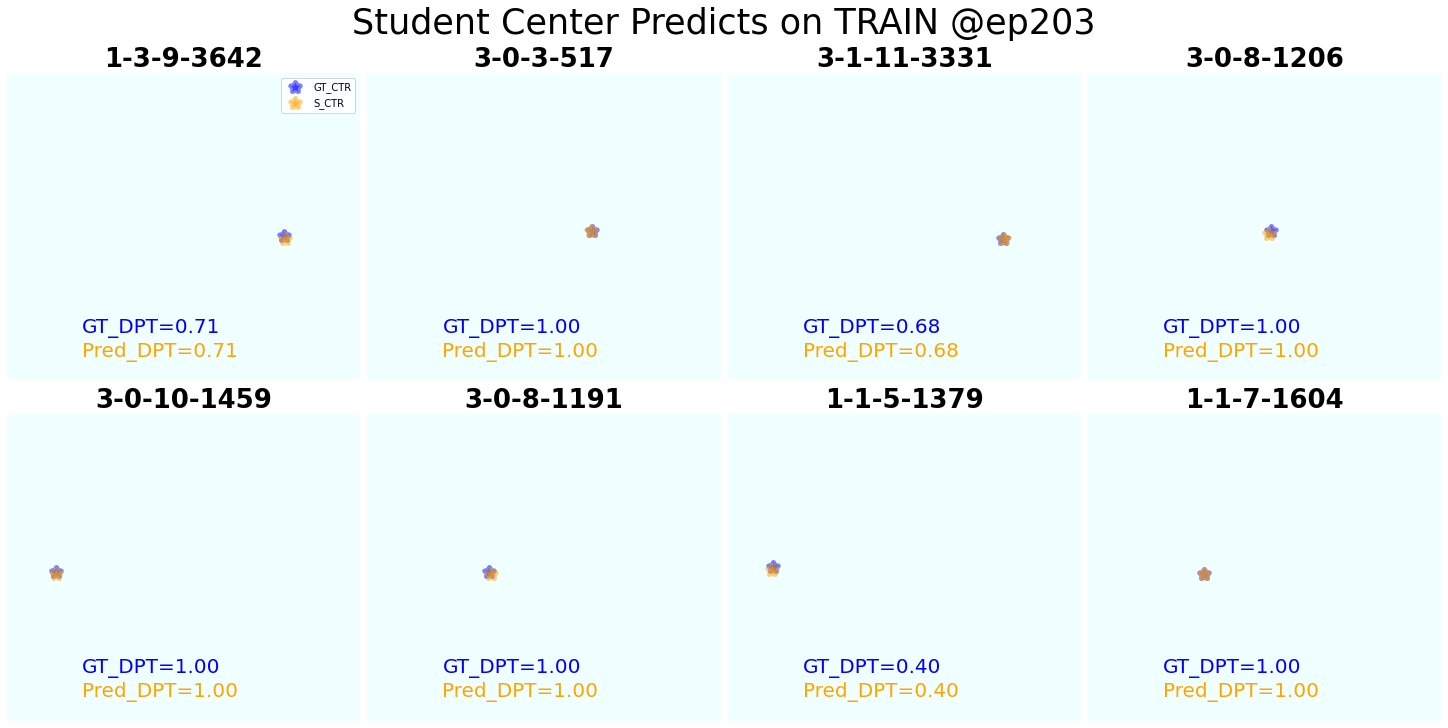

<Figure size 1440x720 with 0 Axes>

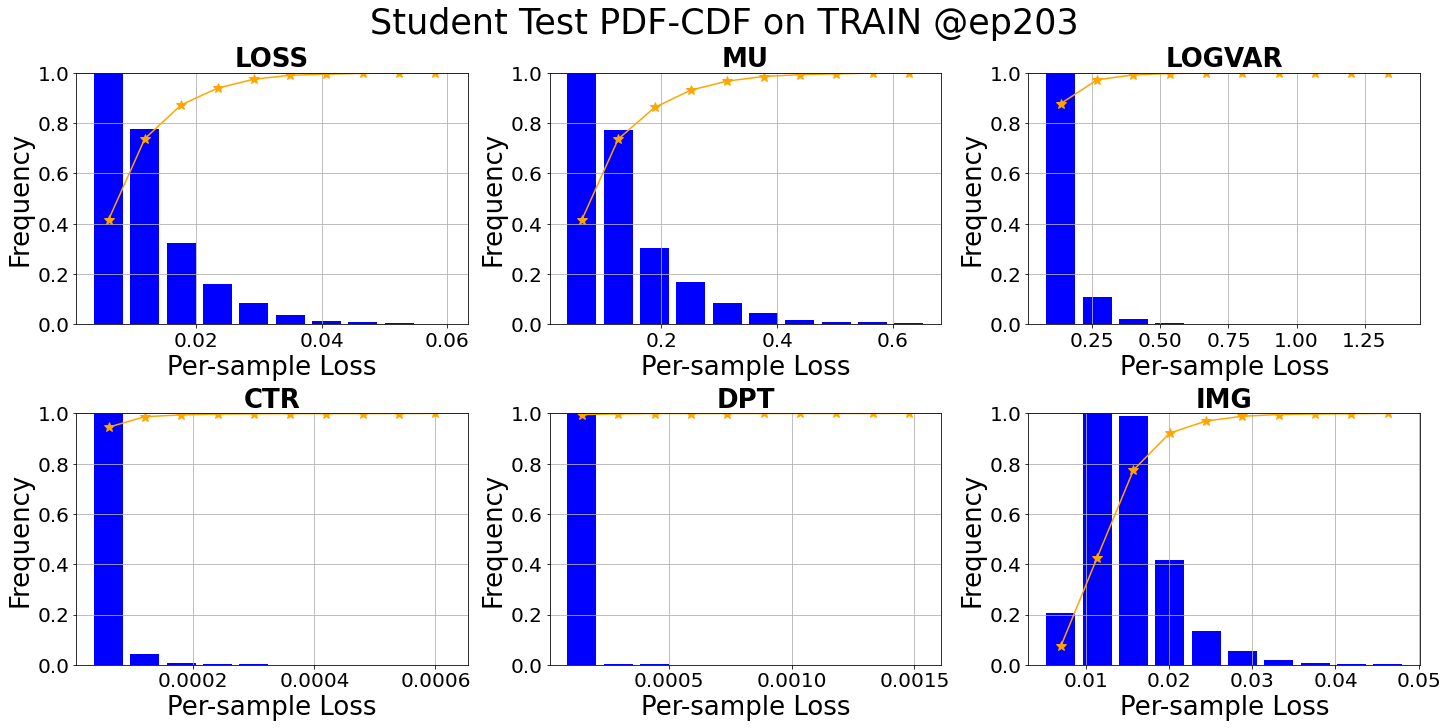

Student test: sample=5295/5299, loss=0.0077    
Test finished. Average loss={'LOSS': 0.042621274342677665, 'MU': 0.13191524270332203, 'LOGVAR': 0.21451661159274482, 'CTR': 0.005659632938735409, 'DPT': 0.02211808919102916, 'IMG': 0.04139219281309521}

Total training time: 88.00212526321411 sec


<Figure size 1440x720 with 0 Axes>

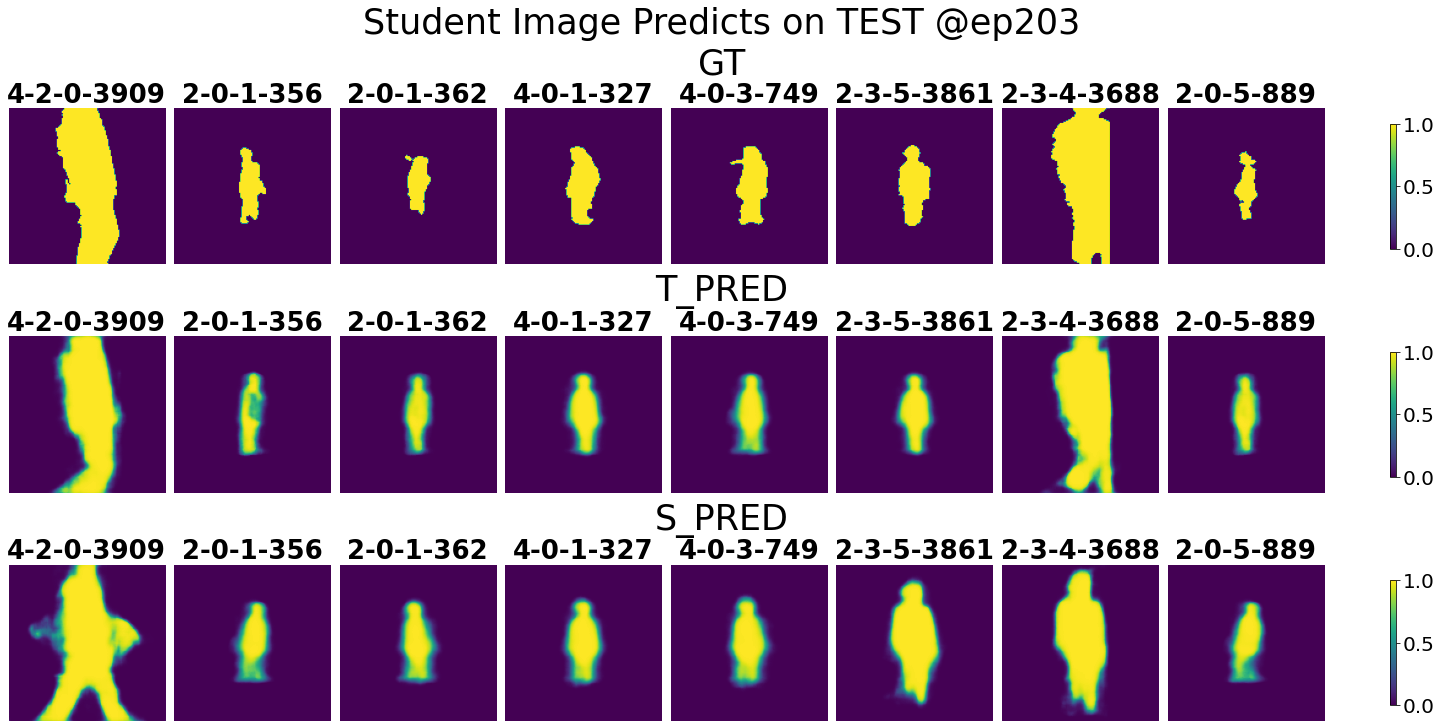

<Figure size 1440x720 with 0 Axes>

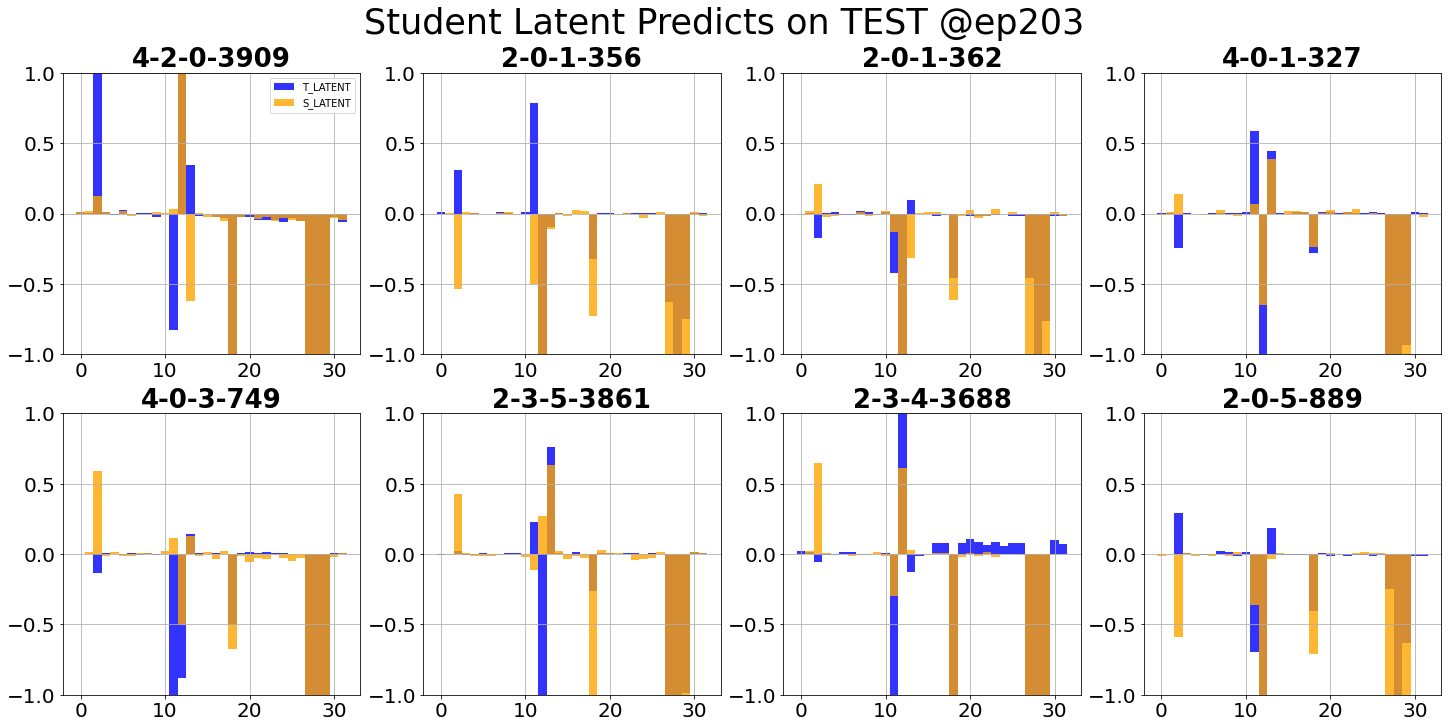

<Figure size 1440x720 with 0 Axes>

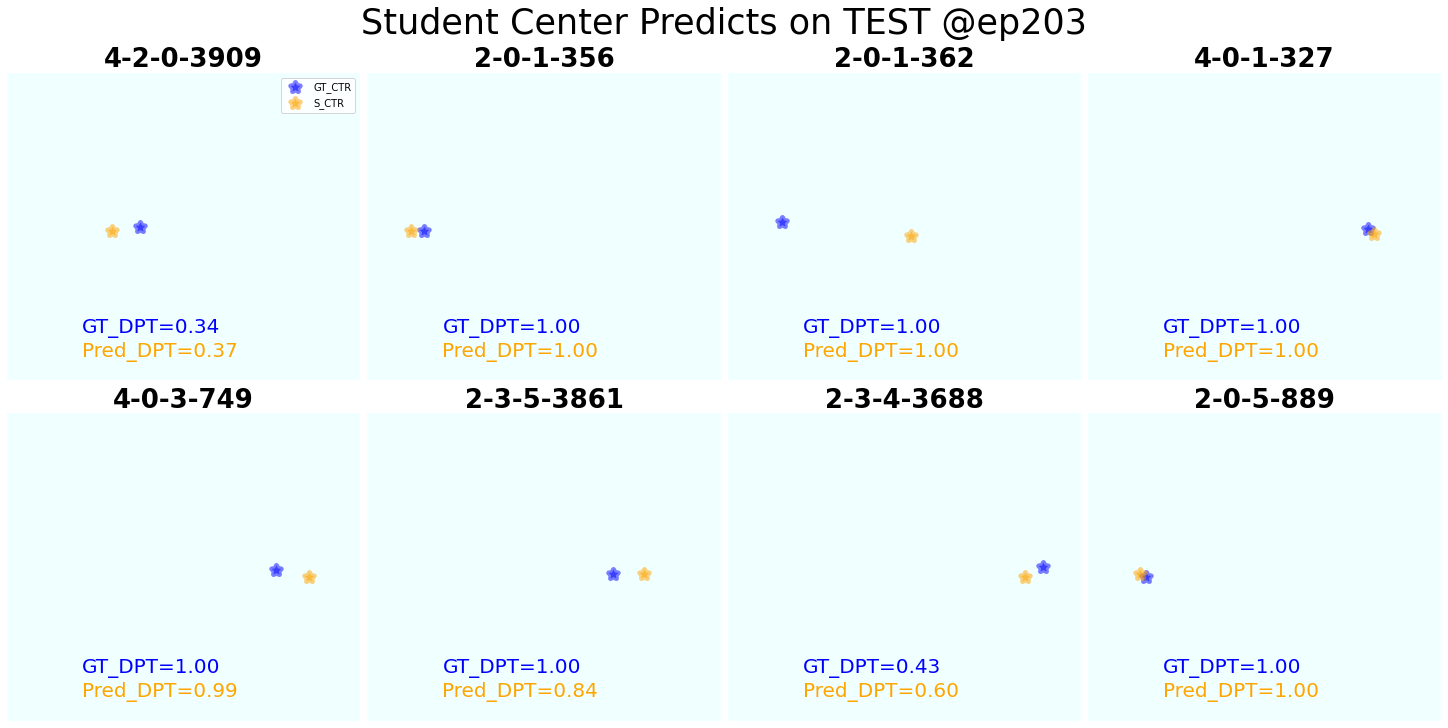

<Figure size 1440x720 with 0 Axes>

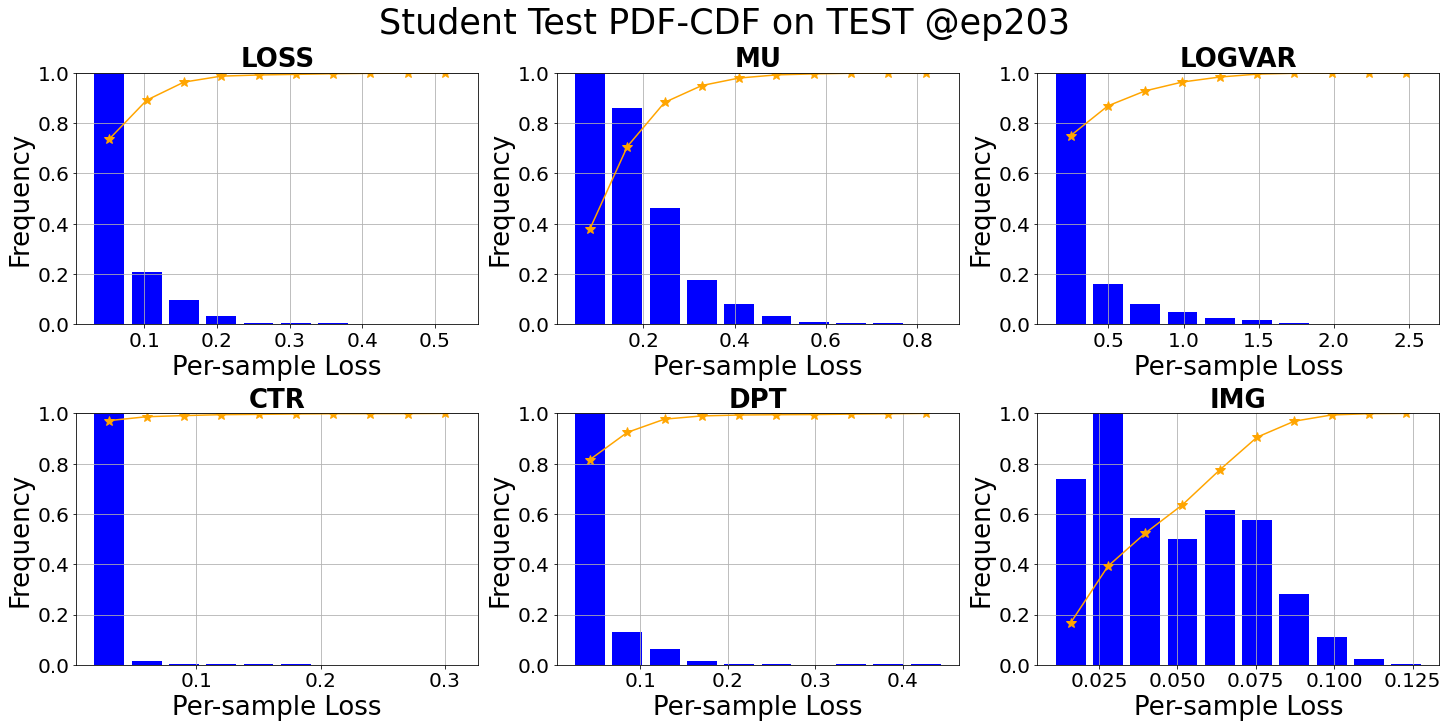

Saving preds: GT...Saving preds: T_PRED...Saving preds: S_PRED...Saving preds: T_LATENT...Saving preds: S_LATENT...Saving preds: GT_CTR...Saving preds: S_CTR...Saving preds: GT_DPT...Saving preds: S_DPT...Saving preds: TAG...Done

Student schedule Completed!


In [5]:
### Scheduler
%matplotlib inline
S_trainer.loss_optimizer = {'LOSS': [torch.optim.Adam, 1e-4]}
S_trained = S_trainer.schedule(lr_decay=True, train_module={'csien', 'ctrde'}, eval_module={'imgen', 'imgde'})

In [15]:
print(S_trainer.temp_loss.items())

dict_items([('LOSS', tensor(0.0285, device='cuda:5')), ('MU', tensor(0.0827, device='cuda:5')), ('LOGVAR', tensor(0.0127, device='cuda:5')), ('IMG', tensor(0.0204, device='cuda:5')), ('CTR', tensor(0.0008, device='cuda:5')), ('DPT', tensor(0.0005, device='cuda:5'))])
